In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [4]:
DATASET_ID = 'european_starling_gentner_segmented'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'starling_128.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/european_starling_gentner_segmented/starling_128.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,rate,spectrogram
3,8.110,9.092,b1060,0,2017-12-08_16-45-25-480000,44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,9.780,10.453,b1060,0,2017-12-08_16-45-25-480000,44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,10.725,11.656,b1060,0,2017-12-08_16-45-25-480000,44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [9]:
len(syllable_df)

101726

In [10]:
import tensorflow as tf

In [11]:
ensure_dir(DATA_DIR / 'tfrecords')

In [12]:
for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df)):
    break

In [13]:
row

start_time                                                  8.11
end_time                                                   9.092
indv                                                       b1060
indvi                                                          0
key                                   2017-12-08_16-45-25-480000
rate                                                       44100
spectrogram    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 3, dtype: object

In [14]:
np.shape(row.spectrogram)

(128, 128)

In [15]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(example):
    """Serialize an item in a dataset
    Arguments:
      example {[list]} -- list of dictionaries with fields "name" , "_type", and "data"

    Returns:
      [type] -- [description]
    """
    dset_item = {}
    for feature in example.keys():
        dset_item[feature] = example[feature]["_type"](example[feature]["data"])
        example_proto = tf.train.Example(features=tf.train.Features(feature=dset_item))
    return example_proto.SerializeToString()

In [16]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [17]:
with tf.io.TFRecordWriter((record_loc).as_posix()) as writer:
    for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df)):
        example = serialize_example(
            {
                "spectrogram": {
                    "data": row.spectrogram.flatten().tobytes(),
                    "_type": _bytes_feature,
                },
                "index": {
                    "data": idx,
                    "_type": _int64_feature,
                },
                "indv": {
                    "data": np.string_(row.indv).astype("|S7"),
                    "_type": _bytes_feature,
                },
            }
        )
        # write the defined example into the dataset
        writer.write(example)

### test read data back

In [18]:
from tensorflow.io import FixedLenFeature, parse_single_example

In [19]:
def _dtype_to_tf_feattype(dtype):
    """ convert tf dtype to correct tffeature format
    """
    if dtype in [tf.float32, tf.int64]:
        return dtype
    else:
        return tf.string
    
def _parse_function(example_proto, data_types):
    """ parse dataset from tfrecord, and convert to correct format
    """
    # list features
    features = {
        lab: FixedLenFeature([], _dtype_to_tf_feattype(dtype))
        for lab, dtype in data_types.items()
    }
    # parse features
    parsed_features = parse_single_example(example_proto, features)
    feat_dtypes = [tf.float32, tf.string, tf.int64]
    
    # convert the features if they are in the wrong format
    parse_list = [
        parsed_features[lab]
        if dtype in feat_dtypes
        else tf.io.decode_raw(parsed_features[lab], dtype)
        for lab, dtype in data_types.items()
    ]
    return parse_list

In [20]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [21]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [22]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [23]:
# shuffle the dataset
dataset = dataset.shuffle(buffer_size=10000)
# create batches
dataset = dataset.batch(10)

In [24]:
spec, index, indv  = next(iter(dataset))

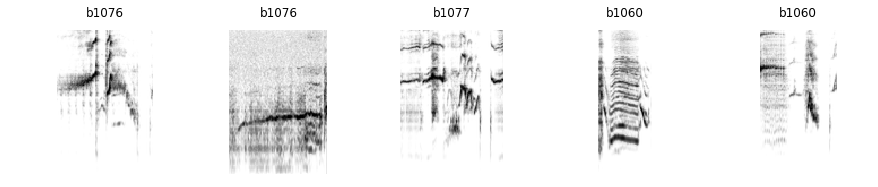

In [25]:
fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i in range(5):
    # show the image
    ax[i].matshow(spec[i].numpy().reshape(128,128), cmap=plt.cm.Greys, origin="lower")
    string_label = indv[i].numpy().decode("utf-8") 
    ax[i].set_title(string_label)
    ax[i].axis('off')